### Segmented Performance Analysis

Following the general exploratory data analysis (EDA), minimal differences were observed in overall correlations. To gain deeper insights, the analysis progresses by segmenting players into performance-based tiers — **Superstars**, **Secondary Stars**, and **Role Players** — allowing for a more targeted comparison of performance patterns.

To ensure fair comparisons across players with varying playing times, an **NPER36** (per-36-minute normalization) column is introduced. This adjustment standardizes player statistics based on playing time, providing a more accurate representation of performance efficiency.

Once normalized, players are categorized according to commonly recognized NBA classifications of **Superstar**, **Secondary Star**, and **Role Player**. This segmentation enables more granular statistical testing and comparative analysis between tiers across both **wins** and **losses**, revealing how player impact may differ depending on game outcomes.

In [1]:
import pandas as pd

# Load both datasets (or start with one)
wins_df = pd.read_csv("../data/NBATrackingDataWins24-25_clean.csv")
losses_df = pd.read_csv("../data/NBATrackingDataLosses24-25_clean.csv")

# Add per-36 normalization for each numeric column (except minutes)
for df in [wins_df, losses_df]:
    if "MIN" in df.columns:
        numeric_cols = df.select_dtypes("number").columns.drop("MIN")
        for col in numeric_cols:
            df[f"{col}_Per36"] = df[col] / df["MIN"] * 36

# Save the updated datasets
wins_df.to_csv("../data/NBATrackingDataWins24-25_per36.csv", index=False)
losses_df.to_csv("../data/NBATrackingDataLosses24-25_per36.csv", index=False)

# Begin to Categorize Players into Specfic Groups 

We will also remove the accents from the dataset so there isn't any confusion

In [2]:
import unicodedata

wins_df = pd.read_csv("../data/NBATrackingDataWins24-25_per36.csv")
losses_df = pd.read_csv("../data/NBATrackingDataLosses24-25_per36.csv")

# Define Superstar and Secondary Star lists
superstars = [
    "Luka Doncic", "Giannis Antetokounmpo", "Nikola Jokic",
    "Jayson Tatum", "Shai Gilgeous-Alexander", "Stephen Curry",
    "LeBron James", "Kevin Durant", "Joel Embiid", "Anthony Davis",
    "Anthony Edwards", "Jalen Brunson", "Victor Wembanyama",
    "Devin Booker", "Kawhi Leonard", "Trae Young", "Donovan Mitchell"
]

secondary_stars = [
    "Jaylen Brown", "Jimmy Butler III", "De'Aaron Fox",
    "Kyrie Irving", "Ja Morant", "Zion Williamson", "Bam Adebayo",
    "Pascal Siakam", "Brandon Ingram", "Domantas Sabonis", "Karl-Anthony Towns",
    "Jamal Murray", "Darius Garland", "Damian Lillard", "Jalen Williams",
    "Paul George", "Scottie Barnes", "Paolo Banchero", "Tyrese Haliburton",
    "Tyrese Maxey", "Lauri Markkanen", "Mikal Bridges", "Franz Wagner",
    "Desmond Bane", "Chet Holmgren", "Kristaps Porzingis", "Jrue Holiday",
    "Dejounte Murray"
]

# Function to strip accents
def remove_accents(name):
    if isinstance(name, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', name)
            if unicodedata.category(c) != 'Mn'
        )
    return name

# Categorize players in both datasets 
def categorize_by_name(player):
    if player in superstars:
        return "Superstar"
    elif player in secondary_stars:
        return "Secondary Star"
    else:
        return "Role Player"

# Apply to both datasets

wins_df["PLAYER"] = wins_df["PLAYER"].apply(remove_accents)
losses_df["PLAYER"] = losses_df["PLAYER"].apply(remove_accents)

wins_df["Tier"] = wins_df["PLAYER"].apply(categorize_by_name)
losses_df["Tier"] = losses_df["PLAYER"].apply(categorize_by_name)

wins_df["Tier"].value_counts()

Tier
Role Player       502
Secondary Star     28
Superstar          17
Name: count, dtype: int64

# Start Conducting Statistical Tests Between the Tiers 

In [3]:
metrics = ["DRIVES_Per36","PTS_Per36", "FGA_Per36","AST_Per36", "PASS_Per36", "TO_Per36", "FTA_Per36", "PF_Per36"]

from scipy import stats

for df, label in [(wins_df, "Wins"), (losses_df, "Losses")]:
    print(f"\n=== {label} ===")
    for metric in metrics:
        f_stat, p_val = stats.f_oneway(
            df[df["Tier"] == "Superstar"][metric],
            df[df["Tier"] == "Secondary Star"][metric],
            df[df["Tier"] == "Role Player"][metric],
        )
        print(f"{metric}: F = {f_stat:.2f}, p = {p_val:.4f}")


=== Wins ===
DRIVES_Per36: F = 34.45, p = 0.0000
PTS_Per36: F = 66.83, p = 0.0000
FGA_Per36: F = 41.24, p = 0.0000
AST_Per36: F = 20.85, p = 0.0000
PASS_Per36: F = 11.40, p = 0.0000
TO_Per36: F = 3.71, p = 0.0251
FTA_Per36: F = 44.56, p = 0.0000
PF_Per36: F = 44.23, p = 0.0000

=== Losses ===
DRIVES_Per36: F = 32.08, p = 0.0000
PTS_Per36: F = 53.44, p = 0.0000
FGA_Per36: F = 33.62, p = 0.0000
AST_Per36: F = 3.53, p = 0.0301
PASS_Per36: F = 10.93, p = 0.0000
TO_Per36: F = 7.64, p = 0.0005
FTA_Per36: F = 49.59, p = 0.0000
PF_Per36: F = 48.76, p = 0.0000


# Interpretation 

In wins, there is a strong distinction between the three tiers. Superstars are scoring, shooting, driving, passing, and drawing fouls more often, which is consistently correlating with wins. 

In losses, the differences remain distinct, but the assists gap is much smaller. The F-value goes from 20.85 in wins to 3.53 in losses. Superstars remain driving to the basket, shooting, and drawing fouls. However, passes and assists drop. 

# Turkey HSD

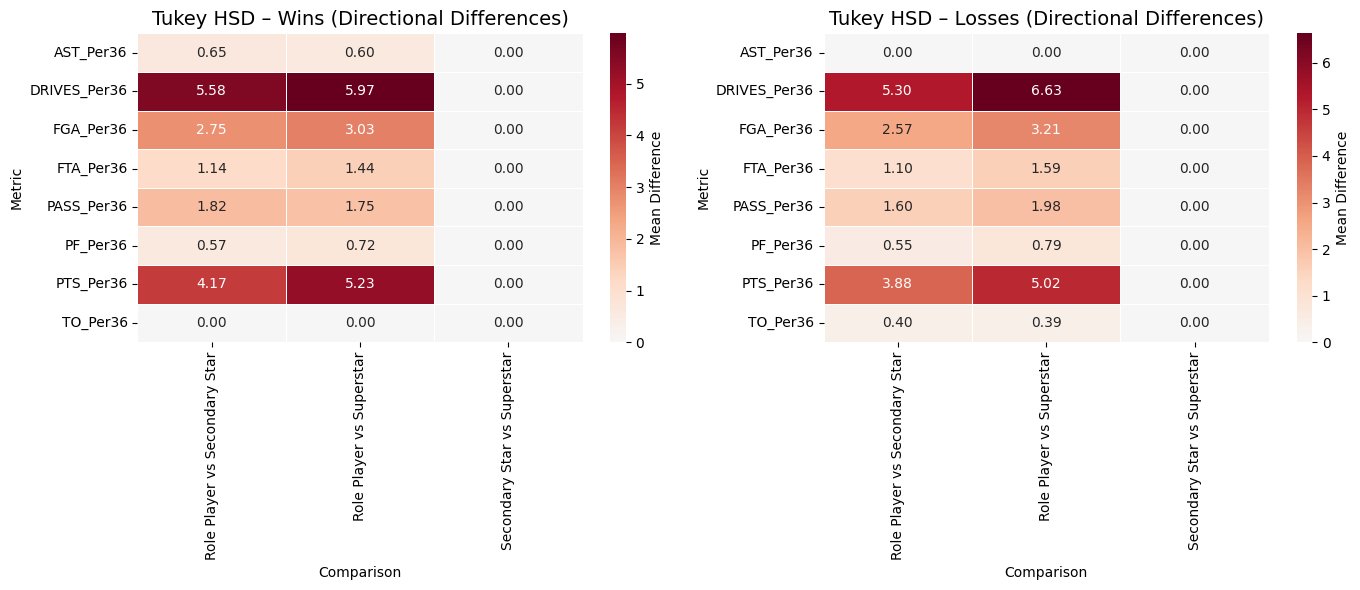

In [4]:
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = [
    "DRIVES_Per36", "PTS_Per36", "FGA_Per36", "AST_Per36", 
    "PASS_Per36", "TO_Per36", "FTA_Per36", "PF_Per36"
]

def get_tukey_results(df, label):
    records = []
    for metric in metrics:
        tukey = pairwise_tukeyhsd(
            endog=df[metric],
            groups=df["Tier"],
            alpha=0.05
        )
        summary_df = pd.DataFrame(
            data=tukey.summary().data[1:],  # skip header
            columns=tukey.summary().data[0]
        )
        summary_df["Metric"] = metric
        summary_df["Dataset"] = label
        records.append(summary_df)
    return pd.concat(records, ignore_index=True)

wins_tukey = get_tukey_results(wins_df, "Wins")
losses_tukey = get_tukey_results(losses_df, "Losses")

def prepare_directional_heatmap_data(tukey_df):
    tukey_df["Comparison"] = tukey_df["group1"] + " vs " + tukey_df["group2"]
    tukey_df["p-adj"] = tukey_df["p-adj"].astype(float)
    tukey_df["meandiff"] = tukey_df["meandiff"].astype(float)
    
    # Encode significance and direction:
    # Positive = group1 > group2
    # Negative = group1 < group2
    # Non-significant = 0
    tukey_df["Effect"] = np.where(
        tukey_df["p-adj"] < 0.05,
        tukey_df["meandiff"],
        0
    )

    # Pivot to heatmap structure
    pivot = tukey_df.pivot_table(
        index="Metric",
        columns="Comparison",
        values="Effect",
        aggfunc="mean"
    ).fillna(0)
    
    return pivot

wins_heatmap = prepare_directional_heatmap_data(wins_tukey)
losses_heatmap = prepare_directional_heatmap_data(losses_tukey)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(
    wins_heatmap, annot=True, cmap="RdBu_r", center=0, linewidths=0.5,
    ax=axes[0], fmt=".2f", cbar_kws={"label": "Mean Difference"}
)
axes[0].set_title("Tukey HSD – Wins (Directional Differences)", fontsize=14)

sns.heatmap(
    losses_heatmap, annot=True, cmap="RdBu_r", center=0, linewidths=0.5,
    ax=axes[1], fmt=".2f", cbar_kws={"label": "Mean Difference"}
)
axes[1].set_title("Tukey HSD – Losses (Directional Differences)", fontsize=14)

plt.tight_layout()
plt.show()

#### **ANOVA Results**
All main metrics showed **statistically significant differences (p < 0.05)** across tiers for both wins and losses.  
This indicates that at least one player tier performed meaningfully differently in each category.

| Metric | Wins (F, p) | Losses (F, p) | Interpretation |
|:-------|:-------------|:--------------|:----------------|
| **DRIVES_Per36** | F = 34.45, p = 0.0000 | F = 32.08, p = 0.0000 | Driving frequency differs significantly among tiers; superstars drive more overall. |
| **PTS_Per36** | F = 66.83, p = 0.0000 | F = 53.44, p = 0.0000 | Strong tier differences in scoring efficiency and usage. |
| **FGA_Per36** | F = 41.24, p = 0.0000 | F = 33.62, p = 0.0000 | Shooting volume is tier-dependent, highest for superstars. |
| **AST_Per36** | F = 20.85, p = 0.0000 | F = 3.53, p = 0.0301 | Playmaking differs significantly, especially in wins. |
| **PASS_Per36** | F = 11.40, p = 0.0000 | F = 10.93, p = 0.0000 | Passing behavior varies by tier. |
| **TO_Per36** | F = 3.71, p = 0.0251 | F = 7.64, p = 0.0005 | Turnover rates differ modestly by tier. |
| **FTA_Per36** | F = 44.56, p = 0.0000 | F = 49.59, p = 0.0000 | Free-throw attempts vary substantially among tiers. |
| **PF_Per36** | F = 44.23, p = 0.0000 | F = 48.76, p = 0.0000 | Foul rates also show clear differences across tiers. |

#### **Turkey HSD Results (Directional Mean Differences)**

Post-hoc **Turkey HSD** comparisons further clarified **where** these differences occur and **which direction** they lean:

- The strongest mean differences are observed between **Role Players and Superstars**, and **Role Players and Secondary Stars**, especially for *Drives*, *PTS*, and *FGA* metrics.  
- **Superstars** consistently exhibit higher values in *Drives* (+5–6 per 36), *PTS* (+4–5), and *FGA* (+2–3), highlighting their dominant offensive role.  
- **Secondary Stars** show smaller but still meaningful increases in offensive metrics compared to Role Players, aligning with their role as complementary scorers and facilitators.  
- **Secondary Star vs. Superstar** comparisons remain near zero across most metrics, confirming that their per-36 statistical profiles are relatively similar despite differences in star power or team dependence.  

The **directional Turkey HSD heatmaps** visualize these patterns clearly:  
Warm tones represent larger positive differences favoring higher tiers, showing how superstars and secondary stars maintain significantly greater offensive involvement compared to role players across both wins and losses.



# Compare Averages Between Tiers (Wins and Losses)

=== Wins Averages ===


,Tier,DRIVES_Per36,PTS_Per36,FGA_Per36,AST_Per36,PASS_Per36,TO_Per36,FTA_Per36,PF_Per36
0,Role Player,5.44,2.77,2.35,0.55,2.23,0.37,0.69,0.35
1,Secondary Star,11.02,6.94,5.10,1.19,4.05,0.62,1.83,0.91
2,Superstar,11.41,8.00,5.38,1.15,3.98,0.66,2.13,1.07


=== Losses Averages ===


,Tier,DRIVES_Per36,PTS_Per36,FGA_Per36,AST_Per36,PASS_Per36,TO_Per36,FTA_Per36,PF_Per36
0,Role Player,5.96,3.00,2.67,0.56,2.35,0.40,0.72,0.37
1,Secondary Star,11.26,6.87,5.24,0.92,3.96,0.80,1.82,0.91
2,Superstar,12.59,8.02,5.88,1.04,4.34,0.79,2.31,1.16


,Tier,DRIVES_Per36_Wins,PTS_Per36_Wins,FGA_Per36_Wins,AST_Per36_Wins,PASS_Per36_Wins,TO_Per36_Wins,FTA_Per36_Wins,PF_Per36_Wins,DRIVES_Per36_Losses,...,FTA_Per36_Losses,PF_Per36_Losses,DRIVES_Per36_Diff,PTS_Per36_Diff,FGA_Per36_Diff,AST_Per36_Diff,PASS_Per36_Diff,TO_Per36_Diff,FTA_Per36_Diff,PF_Per36_Diff
0,Role Player,5.44,2.77,2.35,0.55,2.23,0.37,0.69,0.35,5.96,...,0.72,0.37,-0.52,-0.23,-0.32,-0.02,-0.13,-0.03,-0.03,-0.02
1,Secondary Star,11.02,6.94,5.10,1.19,4.05,0.62,1.83,0.91,11.26,...,1.82,0.91,-0.24,0.07,-0.14,0.27,0.09,-0.18,0.01,0.00
2,Superstar,11.41,8.00,5.38,1.15,3.98,0.66,2.13,1.07,12.59,...,2.31,1.16,-1.18,-0.02,-0.51,0.10,-0.36,-0.13,-0.18,-0.09


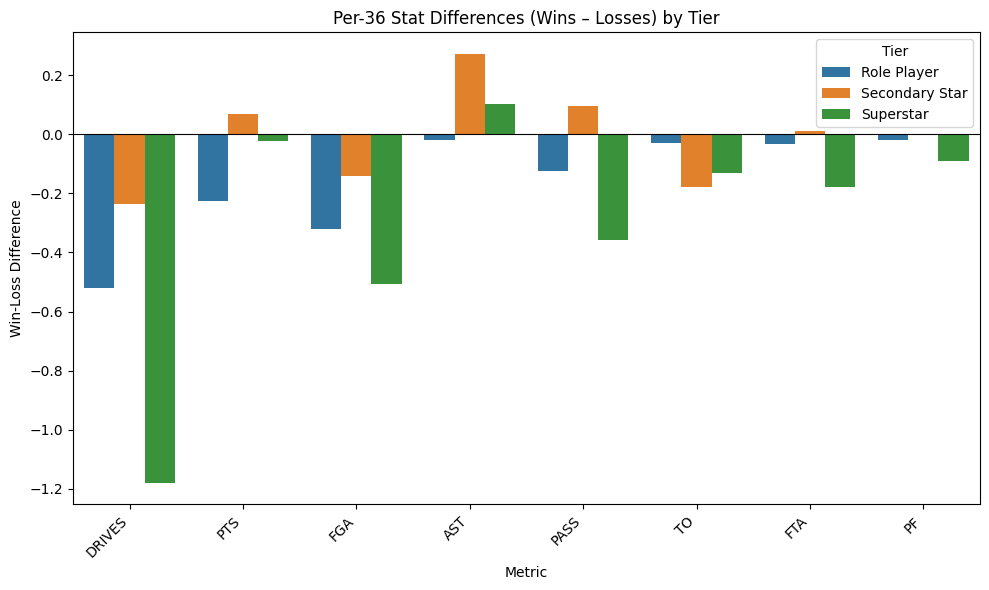

In [5]:
metrics = [
    "DRIVES_Per36", "PTS_Per36", "FGA_Per36", "AST_Per36",
    "PASS_Per36", "TO_Per36", "FTA_Per36", "PF_Per36"
]

# Group and average
wins_avg = wins_df.groupby("Tier")[metrics].mean().reset_index()
losses_avg = losses_df.groupby("Tier")[metrics].mean().reset_index()

print("=== Wins Averages ===")
display(wins_avg.round(2))

print("=== Losses Averages ===")
display(losses_avg.round(2))

# Merge on Tier
tier_comparison = pd.merge(wins_avg, losses_avg, on="Tier", suffixes=("_Wins", "_Losses"))

# Calculate difference between wins and losses
for metric in metrics:
    tier_comparison[f"{metric}_Diff"] = (
        tier_comparison[f"{metric}_Wins"] - tier_comparison[f"{metric}_Losses"]
    )

display(tier_comparison.round(2))

# Melt for easier plotting
melted = tier_comparison.melt(
    id_vars="Tier",
    value_vars=[f"{m}_Diff" for m in metrics],
    var_name="Metric",
    value_name="Win-Loss Difference"
)

# Clean metric names
melted["Metric"] = melted["Metric"].str.replace("_Diff", "").str.replace("_Per36", "")

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x="Metric", y="Win-Loss Difference", hue="Tier")
plt.title("Per-36 Stat Differences (Wins – Losses) by Tier")
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

### Interpretation – Per-36 Stat Differences (Wins vs. Losses)

The analysis of win–loss differences across player tiers reveals distinct behavioral patterns tied to team success.  

- **Superstars** show the **largest negative differences** in metrics such as *Drives*, *FGA*, and *PTS*. This means their teams tend to win when they **don’t need to carry the offensive load**, suggesting that balanced team play leads to better outcomes. In contrast, during losses, superstars take on more isolation-heavy offense, reflecting possible overreliance or inefficiency.  

- **Secondary Stars** demonstrate **smaller overall shifts** but show noticeable **increases in assists and passes** during wins. This indicates that when secondary stars act as facilitators and connectors, their teams benefit the most — emphasizing the value of playmaking balance alongside scoring.  

- **Role Players** remain relatively **consistent across wins and losses**, with only slight declines in scoring and attacking metrics during wins. This suggests their contributions are stable and less dependent on game outcomes, fulfilling complementary roles effectively.  

Overall, these trends highlight that **team victories align with collective balance and ball movement**, while **losses are marked by increased individual usage**, particularly from superstars attempting to carry the offense.
